<h1 align=center><font size = 7>An approach to banking and gambling stratification in Madrid's neighborhoods</font></h1>

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Introduction</a>
2. <a href="#item2">Methodology</a>
   
</font>
</div>

## I. Introduction

### a. Description of the problem and a discussion of the background

The capital of Spain has 3.27 million inhabitants and in the metropolitan area with approximately 6.5 million of citizens. The muncipality covers 604.3 km2 and it's divided in 21 boroughs with a huge unequality in average income per capita between them.

But that kind of business are inside each borough? Does Madrid meets the cliché that banks are in the areas with higher income per capita and lottery retailers and betting shops are in the poorest areas? Are any other criteria to set up in a specific place any of these kind of businesses in the city? 

This analysis trries to classify Madrid neighborhoods based on the concentration of banks and betting shops they have around, taking in account as well the average income per capita in each neighborhood and the average price per square feet for each borough.

In order to reach a conclussion will be used one of the most well known unsupervised machine learning algorithmns: K-Means clustering.


### b. Data description

To consider this problem, will be used:

- Foursquare API, as this is one of the most accurate free APIs to get information about these particular venues in each borough in Madrid
- Geojson files to plot the different neighborhoods in Madrid and show each cluster. Geojson will be used alongside the Folium library.
- The latest information about average square feet prices of Madrid, which can be obtained in the official website of the city.
- The average income of Madrid inhabitants, split by neighborhoods, which was obtained from the Instituto Nacional de Estadística (INE), the official statistical entity in Spain.
- And... lot of Python code, where you can see the whole analysis in this Github's repository.

## II. Methodology

### Loading libraries and preparing the data

In [1]:
%%time

import os
import pandas as pd
import requests #library to handle requests
from pandas.io.json import json_normalize #tranforming json file into a pandas dataframe library
import numpy as np
import seaborn as sns

#conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#Import Machine Learning libraryes
from sklearn.cluster import KMeans ##import KMeans from scikit-learn for clustering
from sklearn.preprocessing import MinMaxScaler

#Pearson correlation analysis
from scipy.stats import pearsonr

Wall time: 4.22 s


The first step will be getting the credentials to access to the Foursquare API to explore the neighborhoods and segment them. They are saved in a Excel file.

In [2]:
#Getting the main directory
os.getcwd()

'C:\\Users\\Jota_Moreno\\Downloads\\Professional Certificate Data Science - IBM\\9. Capstone\\Notebook\\Module_4'

In [3]:
#Changing main directory
os.chdir('C:\\Users\\Jota_Moreno\\Downloads\\Professional Certificate Data Science - IBM\\9. Capstone\\Notebook')

#Getting the name of all Excel files
files = [filename for filename in os.listdir() if filename.endswith("xlsx")]

print(files)

['Foursquare.xlsx']


In [4]:
#Getting the credentials
credentials = pd.read_excel("Foursquare.xlsx")

#Naming the credentials
CLIENT_ID = credentials.loc[0,"CLIENT ID"]
CLIENT_SECRET = credentials.loc[0,"CLIENT SECRET"]
ACCESS_TOKEN = credentials.loc[0,"ACCESS_TOKEN"]
VERSION = '20200507'

### Loading datasets

In [35]:
os.chdir("C:\\Users\\Jota_Moreno\\Downloads\\Professional Certificate Data Science - IBM\\9. Capstone\\Notebook\\Module_4")
madrid_df = pd.read_excel("precio_vivienda.xlsx")
madrid_df.head()

,Distrito,2020-02-01 00:00:00,2020-01-01 00:00:00,2019-12-01 00:00:00,2019-11-01 00:00:00,2019-10-01 00:00:00,2019-09-01 00:00:00,2019-08-01 00:00:00,2019-07-01 00:00:00,2019-06-01 00:00:00,2019-05-01 00:00:00,2019-04-01 00:00:00,2019-03-01 00:00:00,43497,43466,Renta_INE,Unnamed: 16
0,Centro,5088,5096,5059,5043,5010,4994,4993,5044,5031,4991,5034,5069,5033,4987,16147,5037.666667
1,Arganzuela,3894,3983,4019,4043,4030,4059,4073,4096,4085,4080,4095,4071,4042,4017,17306,NaN
2,Retiro,4549,4572,4539,4600,4603,4572,4575,4598,4660,4669,4637,4631,4614,4529,21504,NaN
3,Salamanca,5786,5872,5873,5890,5916,5788,5791,5860,5868,5848,5850,5818,5829,5752,24433,NaN
4,Chamartin,5105,5070,5056,5022,5043,4980,4931,4941,4934,5051,5102,5174,5196,5187,25969,NaN


In [36]:
print(f"There are {madrid_df.shape[0]} districts loaded")

There are 21 districts loaded


In [37]:
#Getting the average for the last 12 months
madrid_df["avg_price"] = madrid_df.iloc[:,1:13].mean(axis=1).round(2)
madrid = madrid_df.loc[:,["Distrito","Renta_INE","avg_price"]]

In [38]:
madrid.head()

,Distrito,Renta_INE,avg_price
0,Centro,16147,5037.67
1,Arganzuela,17306,4044.00
2,Retiro,21504,4600.42
3,Salamanca,24433,5846.67
4,Chamartin,25969,5034.08


In [39]:
madrid_ = madrid.copy()
madrid_ = madrid_.rename(columns={"Distrito":"Borough",
                       "Renta_INE":"Income per capita",
                       "avg_price":"Avg Square Feet price"})
madrid_["Ratio"] = (madrid_["Avg Square Feet price"] / madrid_["Income per capita"]).round(2)

madrid_["Income per capita"] = madrid_["Income per capita"].apply(lambda x : "{:,}".format(x))
madrid_["Avg Square Feet price"] = madrid_["Avg Square Feet price"].apply(lambda x : "{:,}".format(x))
madrid_

,Borough,Income per capita,Avg Square Feet price,Ratio
0,Centro,"16,147","5,037.67",0.31
1,Arganzuela,"17,306","4,044.0",0.23
2,Retiro,"21,504","4,600.42",0.21
3,Salamanca,"24,433","5,846.67",0.24
4,Chamartin,"25,969","5,034.08",0.19
5,Tetuan,"14,970","3,701.92",0.25
6,Chamberi,"22,499","5,301.33",0.24
7,Fuencarral-El Pardo,"18,573","3,466.75",0.19
8,Moncloa-Aravaca,"22,152","3,932.17",0.18
9,Latina,"12,232","2,295.67",0.19


In [40]:
#Pearson correlation analysis
mad_corr = pearsonr(madrid.Renta_INE, madrid.avg_price)
print(f"The correlation between variables is {mad_corr[0].round(4)} with a p-value of {mad_corr[1].round(5)}")

The correlation between variables is 0.903 with a p-value of 0.0


### High correlation
As expected, both variables are highly correlated. There's a strong positive linear relationship between the average income in Madrid's inhabitants and where they live: people with higher incomes, lives in areas with a higher square foot price. Therefore, only one variabe will be used for this analysis. In this case, will be the average income.

The plot of the correlation is the following:

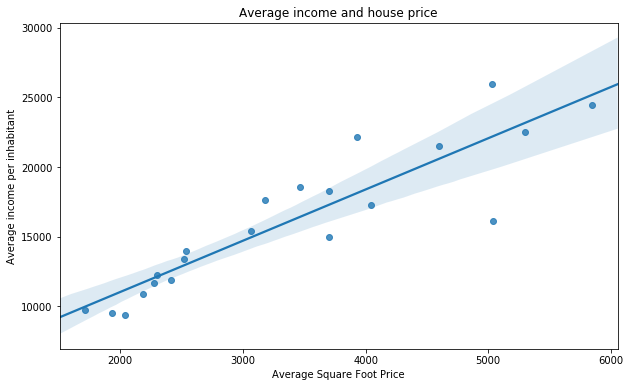

In [41]:
plt.figure(figsize=(10,6))
ax = sns.regplot(x="avg_price", y="Renta_INE", data=madrid)
ax.set_xlabel("Average Square Foot Price")
ax.set_ylabel("Average income per inhabitant")
ax.set_title("Average income and house price")
plt.show()

## Madrid plot - Income per neighborhood

In this part, will be drawn the average income per citizen in each neighborhood. While in general the North part of the city has the highest incomes, the lowest average income is located in the South of Madrid, and specially, in the East.

In [42]:
madrid_geo

'madrid-districts.geojson'

In [44]:
#Using geolocator to obtain Madrid longitude and latitude
address = 'Puerta del Sol, Madrid, SPAIN'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Madrid are {}, {}.\n'.format(latitude, longitude))

#Plotting Madrid map
madrid_geo = r'madrid-districts.geojson'

mad_map = folium.Map(location = [latitude, longitude], zoom_start = 11)
mad_map.choropleth(geo_data=madrid_geo,
                  data=madrid,
                  columns=['Distrito', 'Renta_INE'],
                  key_on='feature.properties.name',
                  fill_color='YlOrRd', 
                  fill_opacity=0.7, 
                  line_opacity=0.2,
                  legend_name='Average income per inhabitant in each district')
mad_map

The geograpical coordinate of Madrid are 40.416865400000006, -3.7043021694877964.



## Getting the latitude and longitude for each district

In order to search in Foursquare the economic business for each district, we will need to have the longitude and latitude for each of them.

The library `geolocator` will be used for this purpose.

In [45]:
#Se realiza un listado de los distritos de Madrid
distritos = madrid["Distrito"].to_list()

In [46]:
distrito_list = []
latitude_list = []
longitude_list = []

for distrito in distritos:
    address = '{}, Madrid, SPAIN'.format(distrito)
    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    distrito_list.append(distrito)
    latitude_list.append(latitude)
    longitude_list.append(longitude)
    print(distrito, "completed")

Centro completed
Arganzuela completed
Retiro completed
Salamanca completed
Chamartin completed
Tetuan completed
Chamberi completed
Fuencarral-El Pardo completed
Moncloa-Aravaca completed
Latina completed
Carabanchel completed
Usera completed
Puente Vallecas completed
Moratalaz completed
Ciudad Lineal completed
Hortaleza completed
Villaverde completed
Villa Vallecas completed
Vicalvaro completed
San Blas-Canillejas completed
Barajas completed


In [47]:
dist_coord = pd.DataFrame(distrito_list, columns=["Distrito"])
dist_coord["Longitude"] = longitude_list
dist_coord["Latitude"] = latitude_list

Once sorted this data, it's possible to plot how average income is distributed in Madrid:

In [48]:
#Using geolocator to obtain Madrid longitude and latitude
address = 'Puerta del Sol, Madrid, SPAIN'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#Plotting Madrid map
madrid_geo = r'madrid-districts.geojson'

mad_map = folium.Map(location = [latitude, longitude], zoom_start = 11)
mad_map.choropleth(geo_data=madrid_geo,
                  data=madrid,
                  columns=['Distrito', 'Renta_INE'],
                  key_on='feature.properties.name',
                  fill_color='YlOrRd', 
                  fill_opacity=0.7, 
                  line_opacity=0.2,
                  legend_name='Average income per inhabitant in each district')


#Adding points for each neighborhood
for lat, lng, label in zip(dist_coord.Latitude, dist_coord.Longitude, dist_coord.Distrito):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color='yellow',
        fill=True,
        popup=label,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(mad_map)


mad_map

We can see that the geographical coordinates of "Villa de Vallecas" are not located accurately. It can be caused due to the similarity in the name with "Puente de Vallecas". Let's search again changing the name

In [49]:
#Looking for the correct geographical coordinates of Villa de Vallecas
address = 'Avenida de la Gavia, Madrid, SPAIN'

geolocator = Nominatim(user_agent="explorer")
location_vv = geolocator.geocode(address)
latitude_vv = location.latitude
longitude_vv = location.longitude

print(location_vv, latitude_vv,longitude_vv)

Avenida de La Gavia, Ensanche de Vallecas, Villa de Vallecas, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España 40.416865400000006 -3.7043021694877964


In [50]:
#Changing the values in the dataframe
dist_coord.loc[17, "Longitude"] = -3.6200
dist_coord.loc[17, "Latitude"] = 40.37592

In [51]:
dist_coord

,Distrito,Longitude,Latitude
0,Centro,-3.707914,40.417653
1,Arganzuela,-3.693734,40.398068
2,Retiro,-3.677441,40.408155
3,Salamanca,-3.674726,40.431527
4,Chamartin,-3.677534,40.460764
5,Tetuan,-3.699520,40.460821
6,Chamberi,-3.703830,40.436247
7,Fuencarral-El Pardo,-3.778591,40.556346
8,Moncloa-Aravaca,-3.744204,40.439495
9,Latina,-3.736152,40.403532


In [52]:
#Using geolocator to obtain Madrid longitude and latitude
address = 'Puerta del Sol, Madrid, SPAIN'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#Plotting Madrid map
madrid_geo = r'madrid-districts.geojson'

mad_map = folium.Map(location = [latitude, longitude], zoom_start = 11)
mad_map.choropleth(geo_data=madrid_geo,
                  data=madrid,
                  columns=['Distrito', 'Renta_INE'],
                  key_on='feature.properties.name',
                  fill_color='YlOrRd', 
                  fill_opacity=0.7, 
                  line_opacity=0.2,
                  legend_name='Average income per inhabitant in each district')


#Adding points for each neighborhood with "Villa de Vallecas" modified
for lat, lng, label in zip(dist_coord.Latitude, dist_coord.Longitude, dist_coord.Distrito):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color='yellow',
        fill=True,
        popup=label,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(mad_map)
  
mad_map

Much better right?

"Villa de Vallecas" is now duly located in the map.

### Getting the banks, betting shops and lottery retailers of each neighborhood

To obtain all the business for a specific neighborhood will be used the FourSquare API. The objective is to obtain all the banks, lottery retailes, casinos and, in general, al the betting shops that could exist.

The way to feed from Foursquare API is giving a geographical point, setting a radius and a set a limit on the number of returning searches inside that radius. For free versions, the number of returning elemts is limited beforehand. It is also necessary to have in mind that, if the radius is big, some business could be overlapping in different negihborhoods, so they must be removed.

The criteria which will be used for this issues would be:
- In order to differentiate the businesses will be used the category ID, obtained from Foursquare developer website.
- Using a loop will be obtained the different business of different radius and merged in the same dataset.
- The dataset will be cleansed removing duplicate results. Each business will be assigned to the neighborhood belongs or it's closer.

In [53]:
#Creating a dictionary with all the categoryIDs to the searched business
business_list = {"BankID" : "4bf58dd8d48988d10a951735",
                 "BettingShopID" : "52f2ab2ebcbc57f1066b8b40",
                 "LotteryID" : "52f2ab2ebcbc57f1066b8b38",
                 "CasinoID" : "4bf58dd8d48988d17c941735",
                 "PawnID" : "52f2ab2ebcbc57f1066b8b34"}

radius = [1000,3000,5000]

In [54]:
#For loop for different radius
def getBussiness(names, latitudes, longitudes, business_list, LIMIT=100, radius=1000):
    
    business_df = pd.DataFrame()
    stack_df = pd.DataFrame()
    
    for business in business_list:
        categoryID = str(business_list[business])
    
        for name, lat, lng in zip(names, latitudes, longitudes):
            print(name, " - ", business)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                categoryID,    
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng,
                radius, 
                LIMIT)

            # make the GET request
            results = requests.get(url).json()["response"]['venues']

            #Create the dataframe
            df = json_normalize(results)
            df["Distrito"] = name
            df["Dist_Latitude"] = lat
            df["Dist_Longitude"] = lng
            df["Business_cat"] = business

            #Hacemos un append al dataframe
            business_df = business_df.append(df)
    
        #Hacemos un append al dataframe
        stack_df = stack_df.append(business_df)    
    
    return(stack_df)

In [55]:
mad_bus = pd.DataFrame()

for each_radius in radius:
    print("Starting loop for radius = ", each_radius, "\n")
    bss = getBussiness(names=dist_coord['Distrito'],
                         latitudes=dist_coord['Latitude'],
                         longitudes=dist_coord['Longitude'],
                         business_list=business_list,
                         radius=each_radius,
                         LIMIT=100
                         )
    mad_bus = mad_bus.append(bss)
    print("\n")

Starting loop for radius =  1000 

Centro  -  BankID
Arganzuela  -  BankID
Retiro  -  BankID
Salamanca  -  BankID


C:\Users\Jota_Moreno\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Chamartin  -  BankID
Tetuan  -  BankID
Chamberi  -  BankID
Fuencarral-El Pardo  -  BankID
Moncloa-Aravaca  -  BankID
Latina  -  BankID
Carabanchel  -  BankID
Usera  -  BankID
Puente Vallecas  -  BankID
Moratalaz  -  BankID
Ciudad Lineal  -  BankID
Hortaleza  -  BankID
Villaverde  -  BankID
Villa Vallecas  -  BankID
Vicalvaro  -  BankID
San Blas-Canillejas  -  BankID
Barajas  -  BankID
Centro  -  BettingShopID
Arganzuela  -  BettingShopID
Retiro  -  BettingShopID
Salamanca  -  BettingShopID
Chamartin  -  BettingShopID
Tetuan  -  BettingShopID
Chamberi  -  BettingShopID
Fuencarral-El Pardo  -  BettingShopID
Moncloa-Aravaca  -  BettingShopID
Latina  -  BettingShopID
Carabanchel  -  BettingShopID
Usera  -  BettingShopID
Puente Vallecas  -  BettingShopID
Moratalaz  -  BettingShopID
Ciudad Lineal  -  BettingShopID
Hortaleza  -  BettingShopID
Villaverde  -  BettingShopID
Villa Vallecas  -  BettingShopID
Vicalvaro  -  BettingShopID
San Blas-Canillejas  -  BettingShopID
Barajas  -  BettingShopI

After the loop, the output is a dataframe with 17.320 rows and 25 columns.

Let's cleean the dataset to wotk with it

In [56]:
mad_bus = pd.read_excel("madrid_businesses - 135.xlsx")

In [57]:
mad_bus.shape

(17320, 25)

In [58]:
mad_bus.columns

Index(['Index', 'Business_cat', 'Dist_Latitude', 'Dist_Longitude', 'Distrito',
       'categories', 'hasPerk', 'id', 'location.address', 'location.cc',
       'location.city', 'location.country', 'location.crossStreet',
       'location.distance', 'location.formattedAddress',
       'location.labeledLatLngs', 'location.lat', 'location.lng',
       'location.neighborhood', 'location.postalCode', 'location.state',
       'name', 'referralId', 'venuePage.id', 'Cat'],
      dtype='object')

In [59]:
#Setting the columns to keep
keep_columns = ["Business_cat","Dist_Latitude","Dist_Longitude","Distrito","id","location.distance","location.lat","location.lng","name","Cat"]
bsd_df = mad_bus[keep_columns]

In [60]:
bsd_df.head(2)

,Business_cat,Dist_Latitude,Dist_Longitude,Distrito,id,location.distance,location.lat,location.lng,name,Cat
0,BankID,40.417653,-3.707914,Centro,4dd24fba7d8b4c6585e834a5,261,40.415558,-3.709305,BBVA Oficina,3km
1,BankID,40.417653,-3.707914,Centro,4d9650b5daec224bdf16143e,1127,40.426469,-3.701367,La Caixa,3km


In [61]:
bsd_df.shape

(17320, 10)

In [62]:
bsd_df = bsd_df.sort_values("location.distance").drop_duplicates(subset=["id"], keep="first").reset_index().drop("index",axis=1)

In [63]:
bsd_df.columns

Index(['Business_cat', 'Dist_Latitude', 'Dist_Longitude', 'Distrito', 'id',
       'location.distance', 'location.lat', 'location.lng', 'name', 'Cat'],
      dtype='object')

We have a total of 1.000 business

In [64]:
bsd_df.shape

(1000, 10)

If looked carefully seems that casinos and betting shops are not clearly split.

In [65]:
lottery_mad = bsd_df[bsd_df["Business_cat"] == "LotteryID"]["name"].unique()
betting_mad = bsd_df[bsd_df["Business_cat"] == "BettingShopID"]["name"].unique()
casino_mad = bsd_df[bsd_df["Business_cat"] == "CasinoID"]["name"].unique()

print("Lottery retailers are:\n\n", lottery_mad,"\n\n")
print("Betting shops are:\n\n", betting_mad,"\n\n")
print("Casinos are:\n\n", casino_mad,"\n\n")

Lottery retailers are:

 ['Loterías Administración 200' 'Doña Manolita'
 'Loterias Y Apuestas del Estado' 'Administración de Loterías 371'
 'Administración de Loterías 1' 'Administración de Loterías Los Gatitos'
 'Eos Administración De Loterías' 'Loterias Maria Sevilla Diago'
 'La Pepita De Oro' 'Administración De Loteria 245' 'El Pez Afortunado'
 'Loterías y Apuestas del Estado Administración 271'
 'Administracion De Loteria  383' 'Administración de Loterías 460'
 'Administración de Lotería 88' 'Loteria'
 'Administración de Lotería Barquillo 10'
 'Administración de Lotería número 529 - Doña Lola'
 'Administración de Lotería 79'
 'Loteria Y Apuestas Del Estado - Administracion 478'
 'Administración Loteria 182'
 'Administración de Lotería número 160 - La Florida'
 'Loterías y Apuestas del Estado Nº 228' 'Administración de Lotería 179'
 'Loterias Y Apuestas Del Estado Ramiro' 'Loterías Y Apuestas Del Estado'
 'Administración de Lotería 267' 'Administración De Loterías N° 402'
 'Loterias

Therefore, all the betting shops, casinos and lottery retailers will be joined in one category: gambling.

In [66]:
bsd_df[bsd_df["Business_cat"] == "BankID"].shape

(794, 10)

In [67]:
bsd_df["Business_cat"] = bsd_df["Business_cat"].replace(["BettingShopID","LotteryID","CasinoID"], "Gambling")

In [68]:
bsd_df["Business_cat"].unique()

array(['BankID', 'Gambling', 'PawnID'], dtype=object)

In [69]:
bsd_df[bsd_df["Business_cat"] == "BankID"].shape

(794, 10)

In [70]:
bsd_df.head()

,Business_cat,Dist_Latitude,Dist_Longitude,Distrito,id,location.distance,location.lat,location.lng,name,Cat
0,BankID,40.417653,-3.707914,Centro,4db6c1a5b3dc51f41340909e,12,40.417552,-3.707848,La Caixa,1km
1,BankID,40.375920,-3.620000,Villa Vallecas,4f0aee7ce4b00a275475a221,23,40.376113,-3.620120,Banco Santander,1km
2,BankID,40.436247,-3.703830,Chamberí,578f47b338faa19a116dd038,36,40.436161,-3.704245,Banco Santander,1km
3,Gambling,40.436247,-3.703830,Chamberí,56c30b77498e0190d1e3d226,37,40.435952,-3.703626,administración de lotería 374,5km
4,BankID,40.436247,-3.703830,Chamberí,4e2e6869b0fbdc2b64f6d5bb,39,40.436038,-3.704211,BBVA Oficina,1km


In [71]:
bsd_df = bsd_df[bsd_df["Business_cat"] != "PawnID"]

In [72]:
bsd_df.shape

(999, 10)

Now it's time to analyze each neighborhood:

In [73]:
# one hot encoding
mad_onehot = pd.get_dummies(bsd_df[['Business_cat']], prefix="", prefix_sep="")
mad_onehot

,BankID,Gambling
0,1,0
1,1,0
2,1,0
3,0,1
4,1,0
...,...,...
995,1,0
996,1,0
997,1,0
998,1,0


In [74]:
# add neighborhood column back to dataframe
mad_onehot['Distrito'] = bsd_df['Distrito']

#Sorting the columns
mad_onehot = mad_onehot[["Distrito","BankID","Gambling"]]
mad_onehot

,Distrito,BankID,Gambling
0,Centro,1,0
1,Villa Vallecas,1,0
2,Chamberí,1,0
3,Chamberí,0,1
4,Chamberí,1,0
...,...,...,...
995,Villaverde,1,0
996,Vicálvaro,1,0
997,Vicálvaro,1,0
998,Villaverde,1,0


The neighborhoods with more gambling shops seems to be the closer to the center: Centro, Chamberí, Salamanca and Tetuán

In [75]:
madrid_grouped = mad_onehot.groupby('Distrito').sum().reset_index()
madrid_grouped.sort_values("Gambling", ascending=False).tail()

,Distrito,BankID,Gambling
1,Barajas,36,3
20,Villaverde,51,3
11,Moratalaz,23,1
19,Villa Vallecas,30,1
7,Fuencarral-El Pardo,2,0


In percetage, the relationship between banks vs gambling places in each negihborhood is:

In [76]:
madrid_grouped_per = mad_onehot.groupby('Distrito').mean()
madrid_grouped_per.sort_values("Gambling", ascending=False).reset_index()

,Distrito,BankID,Gambling
0,Centro,0.522727,0.477273
1,Chamberí,0.597561,0.402439
2,Salamanca,0.704225,0.295775
3,Tetuán,0.742857,0.257143
4,Ciudad Lineal,0.786667,0.213333
5,San Blas-Canillejas,0.791667,0.208333
6,Hortaleza,0.823529,0.176471
7,Arganzuela,0.830508,0.169492
8,Carabanchel,0.840000,0.160000
9,Chamartín,0.854545,0.145455


In [136]:
madrid_grouped = pd.read_excel("madrid_grouped.xlsx")

By contrast, 4 of the top 5 districts districts with less gambling places are the ones which have less average income per inhabitant.

In order to cluster these districts, we need to add to our dataset the average income per inhabitant and the average square foot price per citizen.

In [137]:
madrid_grouped_df = madrid_grouped.merge(madrid, left_on="Distrito", right_on="Distrito")

In [138]:
madrid_grouped_df

,Distrito,BankID,Gambling,Renta_INE,avg_price
0,Arganzuela,49,10,17306,4044.00
1,Barajas,36,3,17641,3176.33
2,Carabanchel,42,8,10872,2188.75
3,Centro,46,42,16147,5037.67
4,Chamartin,47,8,25969,5034.08
5,Chamberi,49,33,22499,5301.33
6,Ciudad Lineal,59,16,15408,3066.00
7,Fuencarral-El Pardo,2,0,18573,3466.75
8,Hortaleza,42,9,18277,3698.58
9,Latina,34,4,12232,2295.67


The K-Means algorithm is really sensitive to distance, so we are going to scale the variables with the MinMaxScaler

In [139]:
X = MinMaxScaler().fit_transform(madrid_grouped_df.iloc[:,1:])

In [140]:
X

array([[0.8245614 , 0.23809524, 0.47731387, 0.56367663],
       [0.59649123, 0.07142857, 0.49752625, 0.35366332],
       [0.70175439, 0.19047619, 0.08911548, 0.11462665],
       [0.77192982, 1.        , 0.40738506, 0.80418734],
       [0.78947368, 0.19047619, 1.        , 0.80331841],
       [0.8245614 , 0.78571429, 0.79063594, 0.86800436],
       [1.        , 0.38095238, 0.36279715, 0.32695873],
       [0.        , 0.        , 0.5537589 , 0.4239574 ],
       [0.70175439, 0.21428571, 0.5358996 , 0.48007019],
       [0.56140351, 0.0952381 , 0.17117171, 0.14050587],
       [0.42105263, 0.07142857, 0.76969953, 0.53660898],
       [0.36842105, 0.02380952, 0.27446603, 0.19917947],
       [0.40350877, 0.0952381 , 0.00905032, 0.05236113],
       [0.73684211, 0.0952381 , 0.73060215, 0.69835411],
       [0.84210526, 0.5       , 0.90732473, 1.        ],
       [0.63157895, 0.23809524, 0.24188488, 0.19508653],
       [0.87719298, 0.42857143, 0.33637022, 0.48087862],
       [0.35087719, 0.07142857,

In [141]:
mad_scaled = pd.DataFrame(X, columns=["Bank","Gambling","Avg_income","Sqft_price"])
mad_scaled["District"] = madrid_grouped_df["Distrito"]
mad_scaled = mad_scaled[["District","Bank","Gambling","Avg_income","Sqft_price"]]

In [142]:
mad_scaled

,District,Bank,Gambling,Avg_income,Sqft_price
0,Arganzuela,0.824561,0.238095,0.477314,0.563677
1,Barajas,0.596491,0.071429,0.497526,0.353663
2,Carabanchel,0.701754,0.190476,0.089115,0.114627
3,Centro,0.771930,1.000000,0.407385,0.804187
4,Chamartin,0.789474,0.190476,1.000000,0.803318
5,Chamberi,0.824561,0.785714,0.790636,0.868004
6,Ciudad Lineal,1.000000,0.380952,0.362797,0.326959
7,Fuencarral-El Pardo,0.000000,0.000000,0.553759,0.423957
8,Hortaleza,0.701754,0.214286,0.535900,0.480070
9,Latina,0.561404,0.095238,0.171172,0.140506


We are going to calculate the idoneous number of clusters based on the elbow method

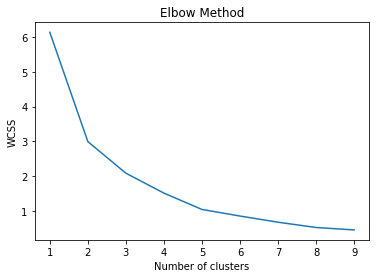

In [143]:
#K-Means Performing. Elbow Method

wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Following the results, we could try between 2 and 5 clusters

In [144]:
clusters_dic = {}

for cluster in range(2,6):
    kmeans = KMeans(n_clusters=cluster).fit(X)
    clusters_dic[cluster] = kmeans.labels_

In [145]:
clusters_dic

{2: array([1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0]),
 3: array([2, 2, 1, 0, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1]),
 4: array([3, 3, 0, 1, 1, 1, 3, 2, 3, 0, 2, 0, 0, 3, 1, 0, 3, 0, 0, 0, 0]),
 5: array([2, 0, 1, 3, 4, 3, 2, 0, 2, 1, 0, 1, 1, 4, 4, 1, 2, 1, 1, 1, 1])}

In [146]:
clus_columns=["K = 2","K = 3","K = 4","K =5"]

clusters_df = pd.DataFrame(clusters_dic)
clusters_df = clusters_df.rename(columns={2 : "K=2",
                           3 : "K=3",
                           4 : "K=4",
                           5 : "K=5"})

In [147]:
madrid_grouped_df = madrid_grouped_df.merge(clusters_df, left_index=True, right_index=True)

In [148]:
madrid_grouped_df

,Distrito,BankID,Gambling,Renta_INE,avg_price,K=2,K=3,K=4,K=5
0,Arganzuela,49,10,17306,4044.00,1,2,3,2
1,Barajas,36,3,17641,3176.33,0,2,3,0
2,Carabanchel,42,8,10872,2188.75,0,1,0,1
3,Centro,46,42,16147,5037.67,1,0,1,3
4,Chamartin,47,8,25969,5034.08,1,2,1,4
5,Chamberi,49,33,22499,5301.33,1,0,1,3
6,Ciudad Lineal,59,16,15408,3066.00,1,2,3,2
7,Fuencarral-El Pardo,2,0,18573,3466.75,0,2,2,0
8,Hortaleza,42,9,18277,3698.58,1,2,3,2
9,Latina,34,4,12232,2295.67,0,1,0,1


In [149]:
madrid_grouped_df = madrid_grouped_df.merge(dist_coord, right_on="Distrito", left_on="Distrito")
madrid_grouped_df.to_excel("madrid_group_df.xlsx")

### Summary

In [150]:
#Using geolocator to obtain Madrid longitude and latitude
address = 'Puerta del Sol, Madrid, SPAIN'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#Plotting Madrid map
madrid_geo = r'madrid-districts.geojson'

# set color scheme for the clusters
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

mad_map = folium.Map(location = [latitude, longitude], zoom_start = 11)
mad_map.choropleth(geo_data=madrid_geo,
                  data=madrid_grouped_df,
                  columns=['Distrito', 'Renta_INE'],
                  key_on='feature.properties.name',
                  fill_color='YlOrRd', 
                  fill_opacity=0.7, 
                  line_opacity=0.2,
                  legend_name='Average income per inhabitant in each district')


#Adding points for each neighborhood with "Villa de Vallecas" modified
for lat, lng, neighborhood, cluster in zip(madrid_grouped_df.Latitude, madrid_grouped_df.Longitude, madrid_grouped_df.Distrito, madrid_grouped_df["K=5"]):
    label = folium.Popup(str(neighborhood) + ', Cluster: ' + str(cluster), parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color=rainbow[cluster-1],
        fill=True,
        popup=label,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.6
    ).add_to(mad_map)
  
mad_map

In [512]:
madrid_grouped_df.groupby("K=5").mean()

,BankID,Gambling,Renta_INE,avg_price,K=2,K=3,K=4
K=5,,,,,,,
0,21.333333,2.000000,19455.333333,3525.083333,0.666667,1.666667,2.333333
1,47.500000,37.500000,19323.000000,5169.500000,0.000000,0.000000,0.000000
2,32.444444,4.222222,11418.666667,2213.473333,1.000000,1.000000,1.000000
3,47.000000,11.000000,23968.666667,5160.390000,0.000000,1.333333,1.333333
4,50.500000,13.250000,16490.250000,3627.625000,0.000000,2.000000,3.000000


When K=5, it's possible to differentiate clearly 5 different groups:
- **Group 0 - Red**: It is made of the Northern districts in the suburbs of Madrid. This group has the lowest number of gambling places and banks and they also have a high average income per citizen.
- **Group 1 - Purple**: It is made of the Southern districts in the suburbs of Madrid. They have some of banks, a very few number of gambling places and the lowest average income per citizen.
- **Group 2 - Blue**: The group with more banks and cannot be fit in other groups.
- **Group 3 - Light Blue**: This group has the districts of the center of Madrid and most of the touristic places. They have more gambling places than any other district and a huge average price per square foot, although the average income per inhabitant is not pretty high.
- **Group 4 - Green**: They are the districts located in the right part of Madrid center. This group has the highest average income per citizen and the second highest average price per square foot, but with not as much gambling places as cluster 2, although there are more banks in that place.